In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import librosa
import soundfile as sf
import io
import IPython
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from util import *

In [2]:
colors = {0: 'purple',
 1: 'blue',
 2: 'red',
 3: 'orange',
 4: 'green',
 5: 'black',
 6: 'teal',
 7: 'maroon',
 8: 'darkslategray',
 9: 'brown'}

def take(n):
    return {k:v for k, v in zip(range(n), colors.values())}

In [3]:
# Build library of all songs (10 genres, 100 songs each)
catalogue = build_catalogue()
library = build_library(catalogue, c_type='list')

Sample rate is:22050


In [7]:
# Find track with smallest number of samples (shortest duration, assuming constant sampling rate):
n_samples = [j.shape[0] for i in library for j in i]
min(n_samples)

660000

In [8]:
# Trim all tracks to n=660000 samples and convert to numpy array. Will have dimensions (10, 100, 660000).
a = []
for n, i in enumerate(library):
    s = []
    for j in i:
        s.append(j[:660000])
    library[n] = s
library = np.array(library)

In [9]:
# Some utility functions to select and downsaple tunes:
def select_tune(genre, tune_n, library, genre_cat = genres):
    genres = {k:v for k, v in zip(genre_cat, range(10))}
    return library[genres[genre]][tune_n]

def down_sample_tune(tune, dsr=5):
    ds_sample = tune.reshape(-1, dsr).mean(axis=1).flatten()
    return ds_sample

In [10]:
# Downsample by factor 5. Have a listen...
tune = select_tune('classical', 25, library)
ds_tune = down_sample_tune(tune, dsr=5)

IPython.display.Audio(ds_tune, rate=22050 / 5)

Text(0, 0.5, 'Fourier component amplitude')

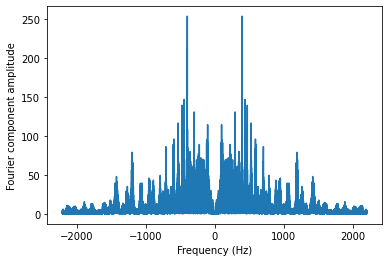

In [14]:
# This is the Fourier transform of the above signal with a Hamming filter:
N = ds_tune.shape[0]
Fs = 22050 / 5
f = np.arange(Fs/-2, Fs/2, Fs/N)
hammingF = np.hamming(N)
s = np.fft.fftshift(np.fft.fft(ds_tune * hammingF))

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(f, np.abs(s))
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Fourier component amplitude')

Text(0, 0.5, 'Frequency (Hz)')

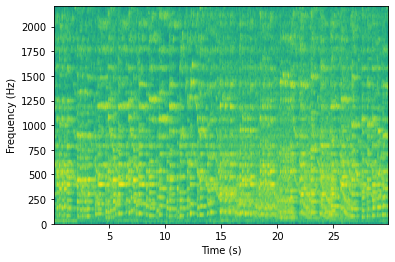

In [15]:
# Spectrogram of the classical piece above:
fig, ax = plt.subplots()
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(ds_tune, Fs=22050 / 5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')

Text(0, 0.5, 'Frequency (Hz)')

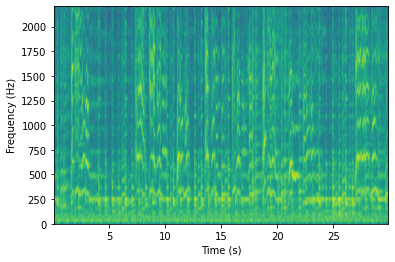

In [28]:
# Spectrogram of a blues tune. Totally different patterns!
tune = select_tune('blues', 15, library)
ds_tune = down_sample_tune(tune, dsr=5)

fig, ax = plt.subplots()
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(ds_tune, Fs=22050 / 5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')

In [33]:
time.shape[0]

1030

In [17]:
# Form data matrix from all blues and classical tracks. The songs are represented by flattened spectrograms:
songs = np.array([])
for i in library[:2, :, :]:
    for j in i:
        ds_tune = down_sample_tune(j, dsr=5)
        f, t, Sxx = signal.spectrogram(ds_tune, fs=22050 / 5, nperseg=1024, window='hanning')
        Sxx[Sxx == 0] = 1
        s = (10 * np.log10(Sxx)).reshape(513 * 147)
        songs = np.concatenate((songs, s))
songs = songs.reshape(200, -1)

In [18]:
# Scale data matrix and find first two pc's:
scaler = StandardScaler()
songs_train = scaler.fit_transform(songs)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(songs_train)

Text(0, 0.5, 'PC 2')

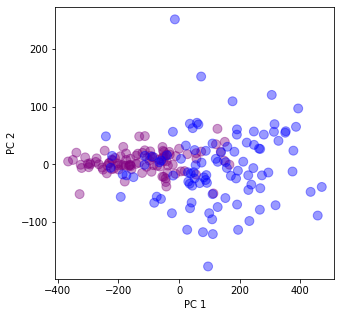

In [21]:
# Plot the first 2 principal components. Some clear separation between the two but classical pc's have larger variance:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(principalComponents[:, 0], principalComponents[:, 1], 
           c=pd.Series(np.repeat(np.arange(2), 100)).map(take(2)).tolist(), s=80, alpha=0.4)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

In [22]:
# Now use all available tracks for all genres:
songs = np.array([])
for i in library:
    for j in i:
        ds_tune = down_sample_tune(j, dsr=5)
        f, t, Sxx = signal.spectrogram(ds_tune, fs=22050 / 5, nperseg=1024, window='hanning')
        Sxx[Sxx == 0] = 1
        s = (10 * np.log10(Sxx)).reshape(513 * 147)
        songs = np.concatenate((songs, s))
songs = songs.reshape(1000, -1)

In [23]:
# Scale data matrix and perform PCA:
scaler = StandardScaler()
songs_train = scaler.fit_transform(songs)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(songs_train)

Text(0, 0.5, 'PC 2')

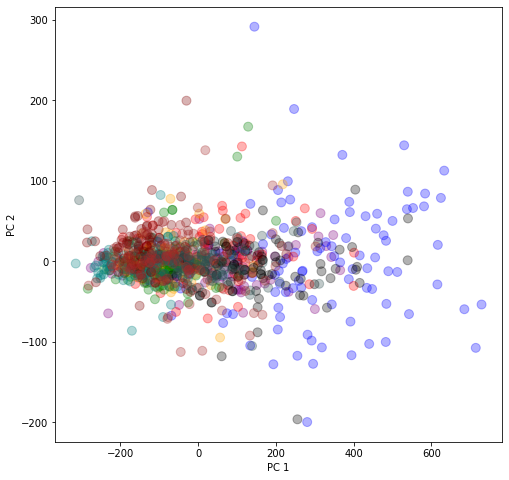

In [24]:
# Amazingly the first two pc's for classical music are distinctly different from all other genres! Every other genre seems to
# be similar, at least by their first pair of pc's.
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(principalComponents[:, 0], principalComponents[:, 1], 
           c=pd.Series(np.repeat(np.arange(10), 100)).map(take(10)).tolist(), s=80, alpha=0.3)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')

In [25]:
# Interesting to investigate how well PCA works for only the Fourier spectrum (just the frequency spectrum not time depndant
# frequency spectrum as in the above). Prepare the data:
songs = np.array([])
Fs = 22050 / 5
for i in library:
    for j in i:
        ds_tune = down_sample_tune(j, dsr=5)
        N = ds_tune.shape[0]
        hammingF = np.hamming(N)
        s = np.fft.fftshift(np.fft.fft(ds_tune * hammingF))
        songs = np.concatenate((songs, s[66000:]))

In [26]:
songs = np.abs(songs.reshape(1000, -1))

scaler = StandardScaler()
songs_train = scaler.fit_transform(songs)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(songs_train)

Text(0, 0.5, 'PC 2')

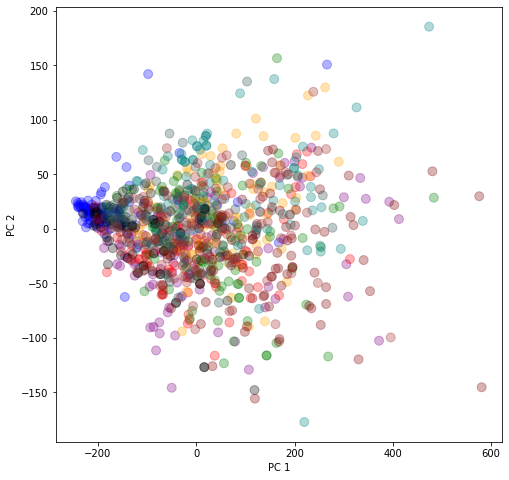

In [27]:
# Again some evident clustering of classical pieces but randomness in all other genres:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(principalComponents[:, 0], principalComponents[:, 1], 
           c=pd.Series(np.repeat(np.arange(10), 100)).map(take(10)).tolist(), s=80, alpha=0.3)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')